In [2]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [5]:
stocks = '^GSPC'
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [6]:
# Calculating the returns of the S&P 500 based on adjusted closing prices
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

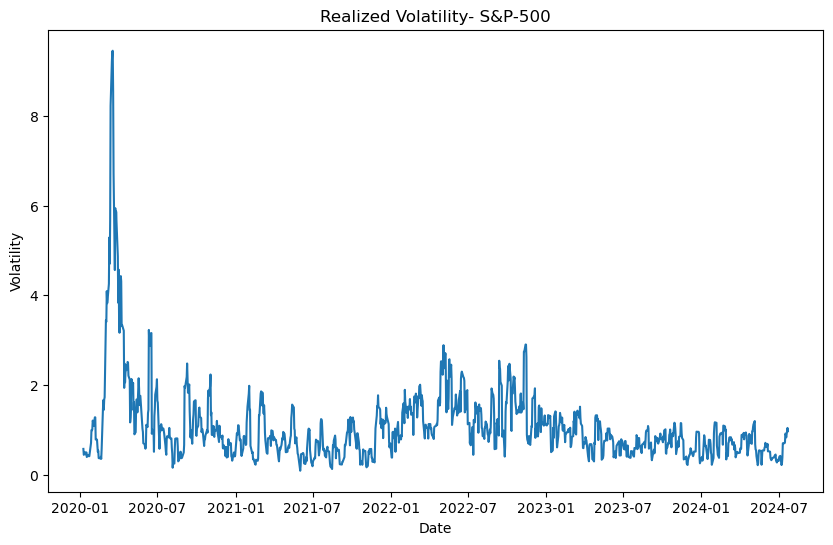

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show() # spikes during covid 

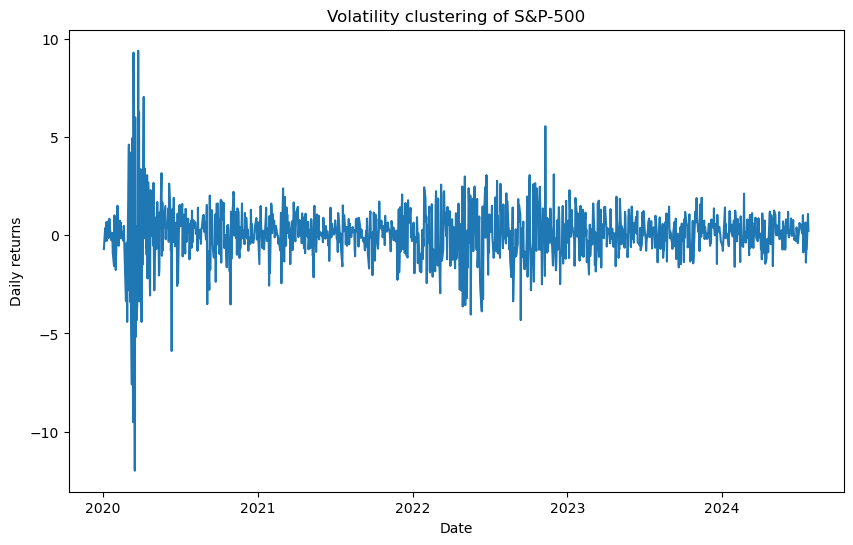

In [8]:
# ARCH model - volatility clustering
retv = ret.values
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show() # large volatility around 2020 confirms results from plot above


# Despite its appealing features, such as simplicity, nonlinearity, easiness, and adjustment for forecast, the ARCH model has certain drawbacks:

# Equal response to positive and negative shocks

# Strong assumptions such as restrictions on parameters

# Possible misprediction due to slow adjustments to large movements

In [9]:
n = 252
# Defining the split location and assigning the split data to split variable
split_date = ret.iloc[-n:].index

In [10]:
# Calculating variance of the S&P 500
sgm2 = ret.var()

# Calculating kurtosis of the S&P 500
K = ret.kurtosis()

# Identifying the initial value for slope coefficient α
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 *
                                     (3.0 * sgm2 - K) * K)) / (6 * K)

# Identifying the initial value for constant term ω
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(1.2082716656026675, 0.36425932872283723)

In [11]:
# Using parallel processing to decrease the processing time
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    # Taking absolute values and assigning the initial values into related variables
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    # Identifying the initial values of volatility
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 # Iterating the variance of S&P 500
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2)) # Calculating the log-likelihood
    return logliks

In [12]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

895.0899693207156

In [13]:
def opt_params(x0, retv):
    # Minimizing the log-likelihood function
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                              method='Nelder-Mead',
                              options={'maxiter': 5000})
    
    # Creating a variable params for optimized parameters
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 779.6171444482552
             x: [ 9.674e-01  4.911e-01]
           nit: 39
          nfev: 77
 final_simplex: (array([[ 9.674e-01,  4.911e-01],
                       [ 9.674e-01,  4.912e-01],
                       [ 9.675e-01,  4.911e-01]]), array([ 7.796e+02,  7.796e+02,  7.796e+02]))

Resulting params = [0.96744878 0.49109049]


In [14]:
def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch
sigma2_arch = arch_apply(ret)

In [15]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1831.90
Distribution:                  Normal   AIC:                           3667.80
Method:            Maximum Likelihood   BIC:                           3677.88
                                        No. Observations:                 1145
Date:                Tue, Jul 23 2024   Df Residuals:                     1145
Time:                        10:17:04   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9679  9.059e-02     10.684  1.212e-26 [  0.790,  1.14

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1706.62
Distribution:                  Normal   AIC:                           3423.23
Method:            Maximum Likelihood   BIC:                           3448.45
                                        No. Observations:                 1145
Date:                Tue, Jul 23 2024   Df Residuals:                     1145
Time:                        10:22:24   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.4308  5.576e-02      7.726  1.112e-14   [  0.32

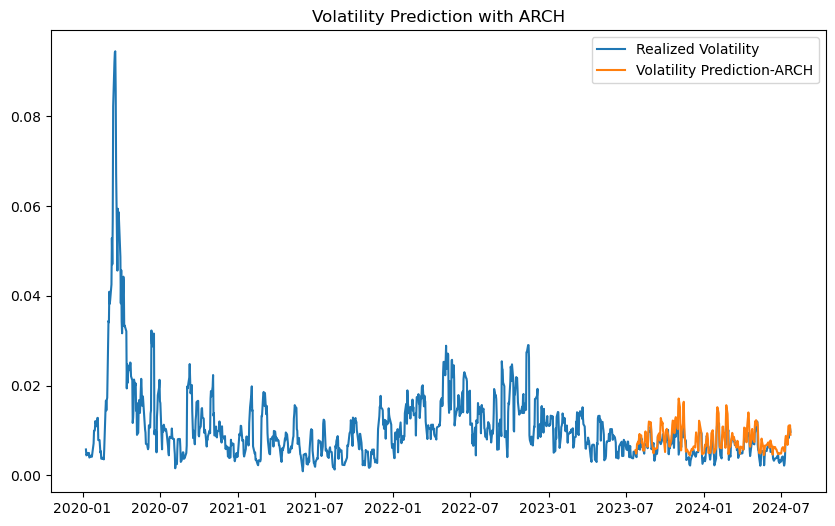

In [17]:
# Bayesian Information Criteria as the model selection method and to select lag

bic_arch = []
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
           .fit(disp='off') # Running ARCH model with different p values
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch): # Finding the minimum BIC score to select the best model
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
       .fit(disp='off') # Running ARCH model with the best p value
print(arch.summary())

# Forecasting the volatility based on the optimized ARCH model
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast


# Calculating the RMSE
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):]
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))



# plot
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [18]:
# GARCH model
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1687.30
Distribution:                  Normal   AIC:                           3380.61
Method:            Maximum Likelihood   BIC:                           3395.73
                                        No. Observations:                 1145
Date:                Tue, Jul 23 2024   Df Residuals:                     1145
Time:                        10:25:20   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0407  1.686e-02      2.417  1.566e-02 [7.

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1687.30
Distribution:                  Normal   AIC:                           3380.61
Method:            Maximum Likelihood   BIC:                           3395.73
                                        No. Observations:                 1145
Date:                Tue, Jul 23 2024   Df Residuals:                     1145
Time:                        10:29:55   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0407  1.686e-02      2.417  1.566e-02 [7.

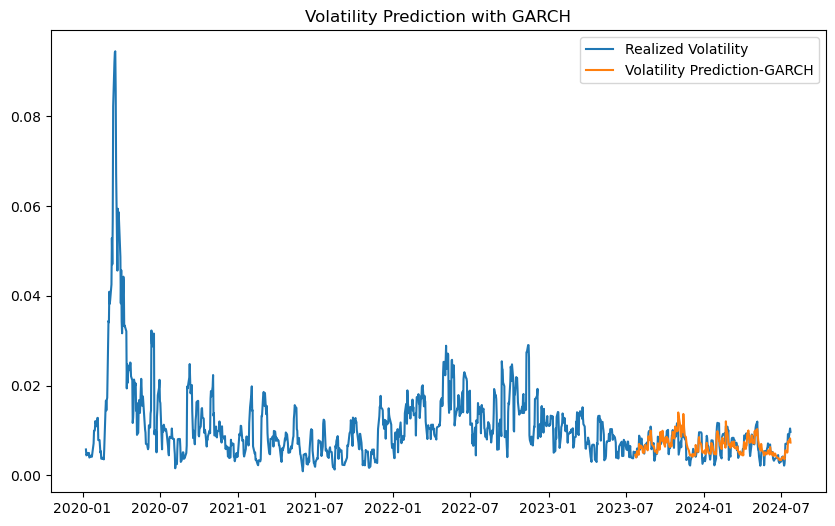

In [20]:
# BIC lowest parameter
bic_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

# RMSE
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):]
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

# plot
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1675.21
Distribution:                  Normal   AIC:                           3358.42
Method:            Maximum Likelihood   BIC:                           3378.59
                                        No. Observations:                 1145
Date:                Tue, Jul 23 2024   Df Residuals:                     1145
Time:                        10:33:42   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0461  2.152e-02      2.140  3.238e-02 [3.

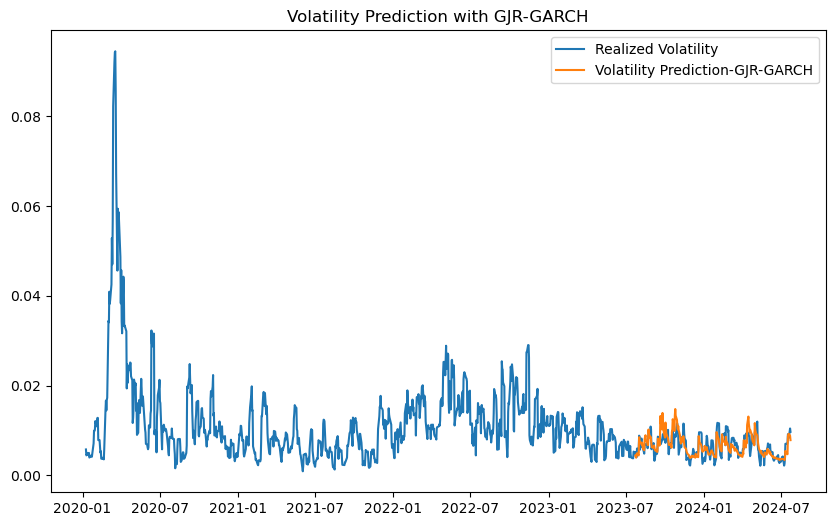

In [22]:
# GJR-GARCH 
bic_gjr_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q)\
                   .fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1,
                      q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast  

# RMSE
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                             np.sqrt(forecast_gjrgarch\
                             .variance.iloc[-len(split_date):]
                            / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

# plot
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100,label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -1691.95
Distribution:                  Normal   AIC:                           3389.90
Method:            Maximum Likelihood   BIC:                           3405.03
                                        No. Observations:                 1145
Date:                Tue, Jul 23 2024   Df Residuals:                     1145
Time:                        10:35:54   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0127  8.421e-03      1.512      0.131 

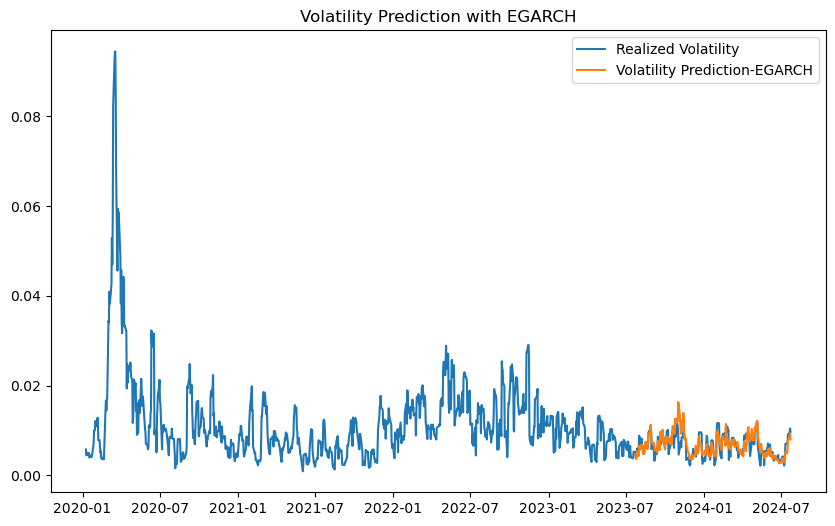

In [24]:
# EGARCH model

bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                 .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH', p=best_param[0], q=best_param[1])\
         .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

# RMSE

rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance\
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

# plot
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

In [25]:
# RMSE results for all four models
from prettytable import PrettyTable 

myTable = PrettyTable(["Model", "RMSE"]) 

# add rows to the table
myTable.add_row(["ARCH", f"{rmse_arch:.3f}" ]) 
myTable.add_row(["GARCH", f"{rmse_garch:.3f}" ]) 
myTable.add_row(["GJR-GARCH", f"{rmse_gjr_garch:.3f}" ]) 
myTable.add_row(["EGARCH", f"{rmse_egarch:.3f}"]) 
print(myTable)

print("The best method for similarity check is:", f"{rmse_garch:.3f}")


+-----------+-------+
|   Model   |  RMSE |
+-----------+-------+
|    ARCH   | 0.083 |
|   GARCH   | 0.075 |
| GJR-GARCH | 0.075 |
|   EGARCH  | 0.076 |
+-----------+-------+
The best method for similarity check is: 0.075


In [29]:
# I am using the best model (GARCH) to predict future volatility and the compare it to realized volatility
forecast_horizon = 10 
garch_forecast = garch.forecast(horizon=forecast_horizon)
predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])
print("Predicted Volatility for the next {} days:".format(forecast_horizon))
print(predicted_volatility) 

Predicted Volatility for the next 10 days:
[0.85444267 0.86728206 0.87961356 0.89146633 0.90286699 0.91383993
 0.9244076  0.93459068 0.94440831 0.95387823]


In [ ]:
def get_realized_vol(dataset, time):
    dataset['returns'] = np.log(dataset["Adj Close"]/dataset["Adj Close"].shift(1))
    dataset.fillna(0, inplace = True)
    volatility = dataset.returns.rolling(window=time).std(ddof=0)*np.sqrt(252)
    return volatility
spx_vol = get_realized_spx_vol(spx, 21)

Volatility Forecast Results
        Date  Realized Volatility  Predicted Volatility
0 2024-07-15               9.3788                0.8544
1 2024-07-16               9.5219                0.8673
2 2024-07-17              13.8010                0.8796
3 2024-07-18              14.6483                0.8915
4 2024-07-19              12.7505                0.9029
5 2024-07-22              14.4937                0.9138
6 2024-07-23              14.0400                0.9244


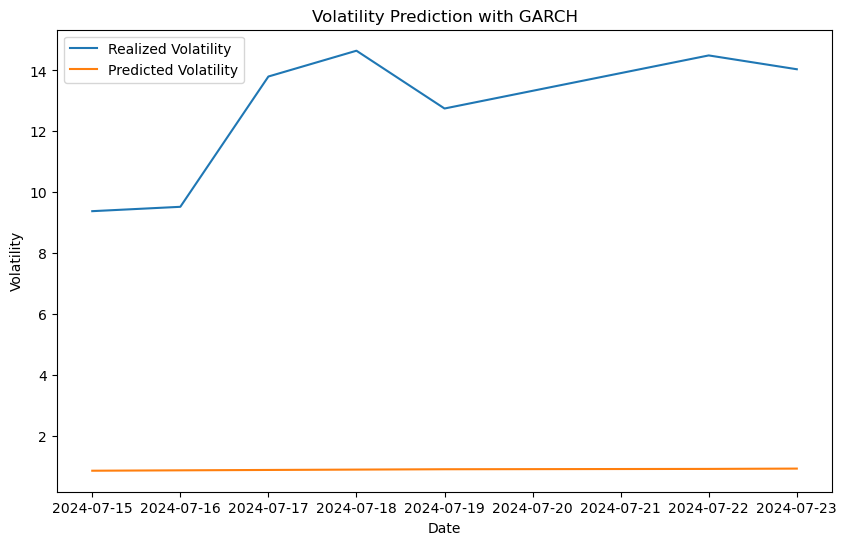

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse

# Forecasting
forecast_horizon = 7  # Number of days to forecast
garch_forecast = garch.forecast(horizon=forecast_horizon)
predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# Calculate realized volatility for the forecast period
realized_volatility = ret.rolling(window=forecast_horizon).std() * np.sqrt(252)  # Annualized
realized_volatility = realized_volatility.dropna()

# Aligning the last 10 values of realized volatility with the forecast period
aligned_realized_volatility = realized_volatility[-forecast_horizon:]

# Ensure the indices of predicted_volatility and aligned_realized_volatility match
predicted_volatility_series = pd.Series(predicted_volatility, index=aligned_realized_volatility.index)

# Prepare results table
results_table = pd.DataFrame({
    'Date': aligned_realized_volatility.index,
    'Realized Volatility': aligned_realized_volatility.values,
    'Predicted Volatility': predicted_volatility_series.values
})

results_table = results_table.round(4)
results_table.reset_index(drop=True, inplace=True)

# Display the results table
print("Volatility Forecast Results")
print(results_table)

# Plot realized vs predicted volatility
plt.figure(figsize=(10, 6))
plt.plot(results_table['Date'], results_table['Realized Volatility'], label='Realized Volatility')
plt.plot(results_table['Date'], results_table['Predicted Volatility'], label='Predicted Volatility')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

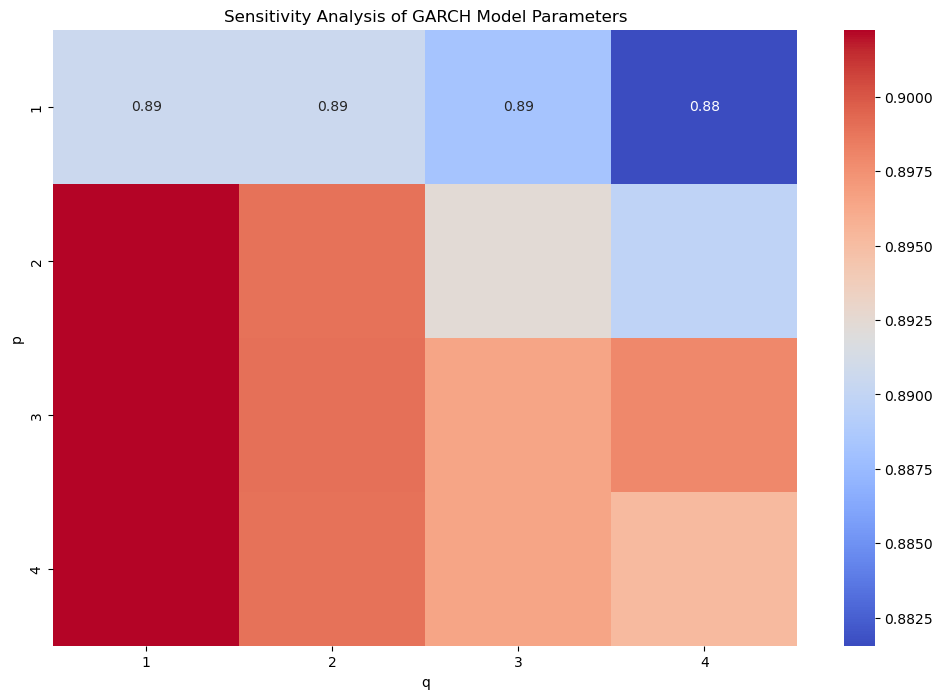

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model

# Assuming 'ret' is already defined and is a pandas Series of returns

# Sensitivity analysis on the parameters
sensitivities = {'p': [], 'q': [], 'volatility': []}
p_values = range(1, 5)
q_values = range(1, 5)
forecast_horizon = 7

for p in p_values:
    for q in q_values:
        model = arch_model(ret, mean='zero', vol='GARCH', p=p, o=0, q=q)
        garch_fit = model.fit(disp='off')
        forecast = garch_fit.forecast(horizon=forecast_horizon)
        predicted_vol = np.sqrt(forecast.variance.values[-1, :])
        sensitivities['p'].append(p)
        sensitivities['q'].append(q)
        sensitivities['volatility'].append(np.mean(predicted_vol))

# Convert to DataFrame for analysis
sensitivity_df = pd.DataFrame(sensitivities)

# Create a pivot table for the heatmap
sensitivity_pivot = sensitivity_df.pivot(index='p', columns='q', values='volatility')

# Plot sensitivity analysis results
plt.figure(figsize=(12, 8))
sns.heatmap(sensitivity_pivot, annot=True, cmap='coolwarm')
plt.title('Sensitivity Analysis of GARCH Model Parameters')
plt.xlabel('q')
plt.ylabel('p')
plt.show()